In [22]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Path to your .mat file
mat_file_path = 'Data/s01.mat' 

mat = loadmat(
    mat_file_path,
    struct_as_record=False,   # access fields as attributes
    squeeze_me=True,          # drop trivial dimensions (so 1x1 -> scalar)
    simplify_cells=True       # convert MATLAB cell arrays to Python lists
)

In [3]:
def walk(name, obj, depth=0, max_depth=6):
    indent = "  " * depth
    if depth > max_depth:
        print(f"{indent}{name}: … (max depth reached)")
        return

    if isinstance(obj, dict):
        print(f"{indent}{name}: dict[{len(obj)}]")
        for k, v in obj.items():
            if not k.startswith("__"):
                walk(f".{k}", v, depth+1, max_depth)
    elif hasattr(obj, "__dict__") and hasattr(obj, "_fieldnames"):
        # scipy loads MATLAB structs as objects with _fieldnames
        print(f"{indent}{name}: matlab_struct with fields {list(obj._fieldnames)}")
        for fld in obj._fieldnames:
            walk(f".{fld}", getattr(obj, fld), depth+1, max_depth)
    elif isinstance(obj, np.ndarray):
        if obj.dtype.names is not None:
            # struct array: each element has named fields
            print(f"{indent}{name}: struct_array shape={obj.shape} fields={obj.dtype.names}")
            it = np.nditer(obj, flags=['refs_ok', 'multi_index'])
            count = 0
            for x in it:
                if count > 3:
                    print(f"{indent}  … ({obj.size - 4} more elements)")
                    break
                walk(f"{name}[{it.multi_index}]", x.item(), depth+1, max_depth)
                count += 1
        elif obj.dtype == object:
            print(f"{indent}{name}: object_array shape={obj.shape}")
            flat = obj.ravel()
            for i, el in enumerate(flat[:4]):
                walk(f"{name}[{i}]", el, depth+1, max_depth)
            if flat.size > 4:
                print(f"{indent}  … ({flat.size - 4} more elements)")
        else:
            print(f"{indent}{name}: ndarray shape={obj.shape} dtype={obj.dtype}")
    else:
        print(f"{indent}{name}: {type(obj).__name__} -> {repr(obj)[:80]}")

In [4]:
for k, v in mat.items():
    if not k.startswith("__"):
        walk(k, v)

eeg: dict[17]
  .noise: object_array shape=(5,)
    .noise[0]: ndarray shape=(68, 5120) dtype=float32
    .noise[1]: ndarray shape=(68, 5120) dtype=float32
    .noise[2]: ndarray shape=(68, 5120) dtype=float32
    .noise[3]: ndarray shape=(68, 5120) dtype=float32
    … (1 more elements)
  .rest: ndarray shape=(68, 34048) dtype=float32
  .srate: int -> 512
  .movement_left: ndarray shape=(68, 71680) dtype=float32
  .movement_right: ndarray shape=(68, 71680) dtype=float32
  .movement_event: ndarray shape=(71680,) dtype=uint8
  .n_movement_trials: int -> 20
  .imagery_left: ndarray shape=(68, 358400) dtype=float32
  .imagery_right: ndarray shape=(68, 358400) dtype=float32
  .n_imagery_trials: int -> 100
  .frame: ndarray shape=(2,) dtype=int16
  .imagery_event: ndarray shape=(358400,) dtype=uint8
  .comment: str -> 'bci2011v1 left/right motor imagery'
  .subject: str -> 'subject 1'
  .bad_trial_indices: dict[2]
    .bad_trial_idx_voltage: object_array shape=(2,)
      .bad_trial_idx_volta

What it means:

Sampling rate: srate = 512 Hz → 1 sample = 1/512 s.

Channels: arrays are (68, N). You also have senloc and psenloc with shape (64, 3), so the first 64 rows are EEG (with 3D sensor locations), and the last 4 are likely aux (EOG/EMG/triggers/etc.).

Electrode Locations:
 - Senloc (Sensor Location) 3D Cartesian coordinates of the 64 EEG electrodes
 - psenloc (Projected Sensor Locations) used for 2D visualization - projection of the 3D coordinates

Trials & durations (do a quick consistency check):

Movement: n_movement_trials = 20, arrays movement_left/right are (68, 71680) → samples per trial = 71680 / 20 = 3584 → 3584/512 = 7.0 s/trial.

Imagery: n_imagery_trials = 100, arrays (68, 358400) → 358400 / 100 = 3584 → 7.0 s/trial.

Noise: 5 segments, each (68, 5120) → 5120/512 = 10.0 s each.

The movement_event and imagery_event vectors (uint8, length equal to the sample count) look like per-sample annotations (e.g., 0=baseline, 1=left, 2=right) concatenated across trials.

In [5]:
eeg = mat["eeg"]  # or whatever your top-level dict key is

srate = int(eeg["srate"])
n_ch_all = 68
n_eeg = 64
eeg_idx = np.arange(n_eeg)
aux_idx = np.arange(n_eeg, n_ch_all)

# Movement
mov_L = eeg["movement_left"]      # (68, 71680)
mov_R = eeg["movement_right"]     # (68, 71680)
mov_evt = eeg["movement_event"]   # (71680,)
n_mov_trials = int(eeg["n_movement_trials"])

samps_per_trial_mov = mov_L.shape[1] // n_mov_trials
assert mov_L.shape[1] % n_mov_trials == 0 and mov_R.shape[1] % n_mov_trials == 0
assert mov_evt.shape[0] == mov_L.shape[1] == mov_R.shape[1]

mov_L_ep = np.reshape(mov_L, (n_ch_all, samps_per_trial_mov, n_mov_trials), order="F")
mov_R_ep = np.reshape(mov_R, (n_ch_all, samps_per_trial_mov, n_mov_trials), order="F")
mov_evt_ep = np.reshape(mov_evt, (samps_per_trial_mov, n_mov_trials), order="F")

# Imagery
img_L = eeg["imagery_left"]       # (68, 358400)
img_R = eeg["imagery_right"]      # (68, 358400)
img_evt = eeg["imagery_event"]    # (358400,)
n_img_trials = int(eeg["n_imagery_trials"])

samps_per_trial_img = img_L.shape[1] // n_img_trials
assert img_L.shape[1] % n_img_trials == 0 and img_R.shape[1] % n_img_trials == 0
assert img_evt.shape[0] == img_L.shape[1] == img_R.shape[1]

img_L_ep = np.reshape(img_L, (n_ch_all, samps_per_trial_img, n_img_trials), order="F")
img_R_ep = np.reshape(img_R, (n_ch_all, samps_per_trial_img, n_img_trials), order="F")
img_evt_ep = np.reshape(img_evt, (samps_per_trial_img, n_img_trials), order="F")

# Noise segments are already separate blocks in an object array
noise_blocks = [eeg["noise"][i] for i in range(eeg["noise"].shape[0])]  # each (68, 5120)

# Time vectors
t_mov = np.arange(samps_per_trial_mov) / srate
t_img = np.arange(samps_per_trial_img) / srate


In [6]:
print(np.unique(img_evt_ep) )                # see codes
print(len(img_evt_ep[:, 0]))     # length 3584


[0 1]
3584


In [7]:
print(mov_L.shape)

(68, 71680)


In [8]:
print(mov_L[:,:10].shape)

(68, 10)


In [9]:
np.savetxt('mov_L_head.csv', mov_L[:,:10], delimiter=',', fmt='%d')

In [10]:
# Exploring Sensor Location
senloc = eeg["senloc"]
psenloc = eeg["psenloc"]

print(senloc.shape)
print(psenloc.shape)

(64, 3)
(64, 3)


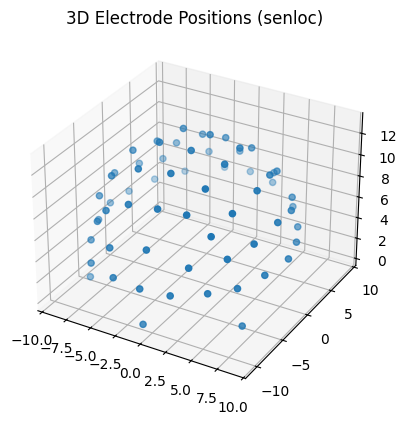

In [11]:
# 3D electrode layout
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(senloc[:,0], senloc[:,1], senloc[:,2])
ax.set_title("3D Electrode Positions (senloc)")
plt.show()

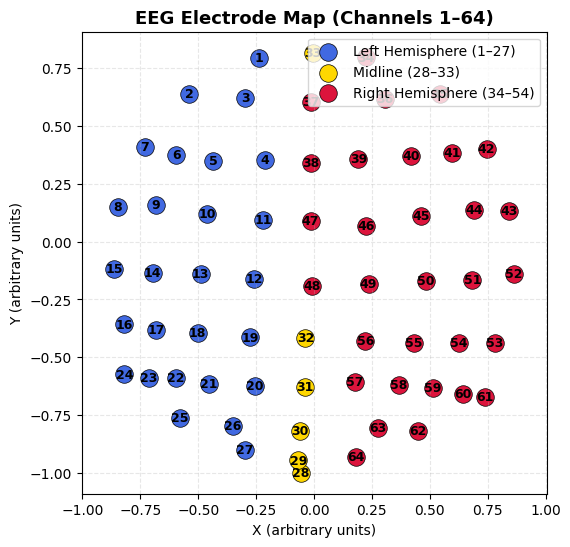

In [26]:
plt.figure(figsize=(6,6))

# Define index ranges (1-based for readability)
left_idx  = np.arange(0, 27)   # channels 1–27
mid_idx   = np.arange(27, 33)  # channels 28–33
right_idx = np.arange(33, 64)  # channels 34–64

point_size = 160

# Plot electrodes by hemisphere
plt.scatter(psenloc[left_idx,0],  psenloc[left_idx,1],
            s=point_size, color="royalblue", edgecolor="black", linewidth=0.5, label="Left Hemisphere (1–27)")
plt.scatter(psenloc[mid_idx,0],   psenloc[mid_idx,1],
            s=point_size, color="gold", edgecolor="black", linewidth=0.5, label="Midline (28–33)")
plt.scatter(psenloc[right_idx,0], psenloc[right_idx,1],
            s=point_size, color="crimson", edgecolor="black", linewidth=0.5, label="Right Hemisphere (34–54)")

# Label all channels (1–64)
for i, (x, y) in enumerate(psenloc[:, :2], start=1):
    plt.text(x, y, str(i),
             fontsize=9, fontweight='bold',
             ha="center", va="center",
             color="black")

plt.title("EEG Electrode Map (Channels 1–64)", fontsize=13, fontweight='bold')
plt.xlabel("X (arbitrary units)")
plt.ylabel("Y (arbitrary units)")
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="upper right", frameon=True)
plt.show()
